In [131]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
from sklearn import linear_model
from helper.plot_pr_roc import plot_pr_curve, plot_roc_curve
import warnings
warnings.filterwarnings("ignore")
import matplotlib
font = {'size': 10}
matplotlib.rc('font', **font)
matplotlib.rcParams['axes.linewidth'] = 0.5


from config.paths import TRAIN_FILE
from config.paths import OUT_FIG_DIR, OUT_DATA_DIR
from lib.agent import Agent
from lib.helper import bootstrapping, prepare_data
from tqdm import tqdm
import matplotlib.pyplot as plt

In [133]:
TRAIN_FILE

'..//data/Sept-2019-ML-processing.csv'

In [134]:
df = pd.read_csv(TRAIN_FILE).drop(columns=['Gene_name'])

In [135]:
df = pd.read_csv(TRAIN_FILE).drop(columns=['Gene_name'])
df_train, df_test = prepare_data(TRAIN_FILE) 

In [136]:
weights = []
for seed in tqdm(range(500)):
    data_train = bootstrapping(df_train, seed)
    agent = Agent(data_train, df_test, costs=[1, 5, 10, 15, 100, 100], bootstrapping=True)
    agent.run()
    weights.append(agent.model.coef_[0,: ])

100%|██████████| 500/500 [14:08<00:00,  1.62s/it]


In [137]:
weights = np.abs(np.stack(weights))
weights = pd.DataFrame(weights).T
weights.index = df_train.columns[:-1]
weights['sum'] = weights.sum(axis=1)
weights.sort_values(by=['sum'], inplace=True)

In [138]:
weight_path = OUT_DATA_DIR + "/weights.csv"

In [139]:
weights.to_csv(weight_path)

In [140]:
w_mean = np.mean(weights.iloc[:, :-1], axis=1)
w_std = np.std(weights.iloc[:, :-1], axis=1)/np.sqrt(weights.shape[1]-1)
features = weights.index

In [141]:
fig_path = OUT_FIG_DIR + "/weight.pdf"

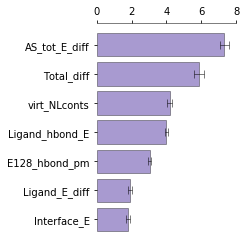

In [142]:
fig, ax = plt.subplots(figsize=(2.5, 4))

pos = np.arange(w_mean.shape[0])
error = w_std
thickness = 0.5

ax.barh(pos, w_mean, xerr=error, align='center', color=['#8370BC'] * 4,
        edgecolor='black',linewidth=thickness, alpha=0.7, 
        error_kw=dict(ecolor='black', lw=thickness, capsize=4, capthick=thickness))

ax.set_yticks(pos)
ax.set_yticklabels(features)
ax.xaxis.tick_top()
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim(0, 8)
plt.savefig(fig_path, bbox_inches='tight')